# Exercise 4: Ridge Regression on the Franke function  with resampling (score 20 points)

Write your own code for the Ridge method, either using matrix
inversion or the singular value decomposition as done in the previous
exercise. Perform the same bootstrap analysis as in the
Exercise 2  (for the same polynomials) and the cross-validation  in exercise 3 but now for different values of $\lambda$. Compare and
analyze your results with those obtained in exercises 1-3. Study the
dependence on $\lambda$.

Study also the bias-variance trade-off as function of various values of
the parameter $\lambda$. For the bias-variance trade-off, use the **bootstrap** resampling method. Comment your results. 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import  train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter



def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def FrankeFunctionWithNoise(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.1, len(x)*len(x))
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise


def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)


Polynomial degree: 3
Log10(Lambda): -3.0
---------Bootstrap---------
Error: 0.023529689940396413
Bias^2: 0.023109849161427297
Var: 0.00041984077896911365
0.023529689940396413 >= 0.023109849161427297 + 0.00041984077896911365 = 0.02352968994039641
---------Cross Validation---------
Error_sklearn: 0.03460946626469905



Polynomial degree: 3
Log10(Lambda): -2.919191919191919
---------Bootstrap---------
Error: 0.023737997276303307
Bias^2: 0.023185069962098487
Var: 0.0005529273142048191
0.023737997276303307 >= 0.023185069962098487 + 0.0005529273142048191 = 0.023737997276303307
---------Cross Validation---------
Error_sklearn: 0.034733559455860555



Polynomial degree: 3
Log10(Lambda): -2.8383838383838382
---------Bootstrap---------
Error: 0.023865805939569277
Bias^2: 0.0233659017031075
Var: 0.0004999042364617799
0.023865805939569277 >= 0.0233659017031075 + 0.0004999042364617799 = 0.02386580593956928
---------Cross Validation---------
Error_sklearn: 0.03490382423043026



Polynomial degree: 3

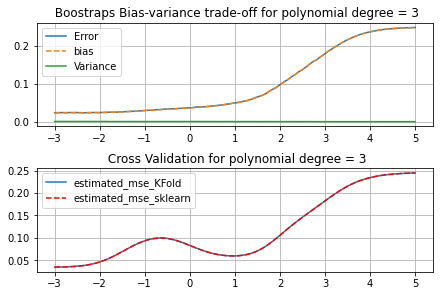

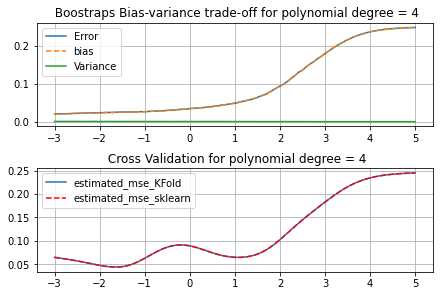

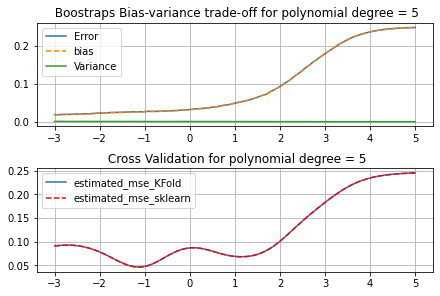

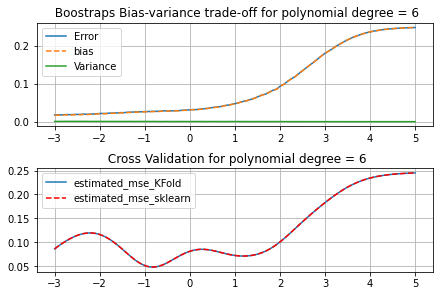

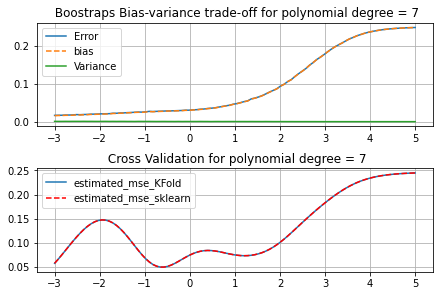

In [19]:
################# Parameters #################

n = 20  #number of data
polynomial = 10 #polynomial degree
list_degree = [3, 4, 5, 6, 7]
k = 5 #number of splits
n_bootstraps = 20
nlambdas = 100
lambdas = np.logspace(-3, 5, nlambdas)

#############################################

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x, y)
z = FrankeFunctionWithNoise(x, y)
z = z.ravel()


x_y = np.empty((len(x)*len(x), 2))
x_y[:, 0] = x.ravel()
x_y[:, 1] = y.ravel()
x_y_train, x_y_test, z_train, z_test = train_test_split(x_y, z.ravel(), test_size=0.2)


kfold = KFold(n_splits=k)

min_error = []
min_lambdas = []

for degree in list_degree:

    scores_KFold = np.zeros((nlambdas, k))
    estimated_mse_sklearn = np.zeros(nlambdas)


    error = np.zeros(lambdas.shape[0])
    bias = np.zeros(lambdas.shape[0])
    variance = np.zeros(lambdas.shape[0])


    j = 0
    
    
    poly = PolynomialFeatures(degree=degree)
    
    
    for l in lambdas:

        ridge = Ridge(alpha=l, fit_intercept=False)
        pred_test = np.empty((z_test.shape[0], n_bootstraps))
        pred_train = np.empty((z_train.shape[0], n_bootstraps))

        
        
        for i in range(n_bootstraps):
            x_y_, z_ = resample(x_y_train, z_train)
            X_train = create_X(x_y_[:, 0], x_y_[:, 1], degree)
            X_test = create_X(x_y_test[:, 0], x_y_test[:, 1], degree)
            RidgeBeta = np.linalg.pinv(X_train.T.dot(X_train) + l * np.eye(X_train.T.dot(X_train).shape[0])).dot(X_train.T).dot(z_)
            pred_test[:, i] = X_test @ RidgeBeta
            pred_train[:, i] = X_train @ RidgeBeta


        z_pred_kfold  = np.empty((int(z.shape[0] / k), k))
        h = 0

     
        
        for train_index, test_index in kfold.split(x_y):
            x_train_kfold, x_test_kfold  = x_y[train_index], x_y[test_index]
            z_train_kfold, z_test_kfold = z[train_index], z[test_index]

            X_train = poly.fit_transform(x_train_kfold)
            ridge.fit(X_train, z_train_kfold)
            Xtest = poly.fit_transform(x_test_kfold)
            zpred = ridge.predict(Xtest)
            scores_KFold[j, h] = np.sum((zpred - z_test_kfold) ** 2) / np.size(zpred)
            z_pred_kfold[:, h] = zpred
            h += 1

        
        
        
        X = poly.fit_transform(x_y)
        estimated_mse_folds = cross_val_score(ridge, X, z, scoring='neg_mean_squared_error',cv=kfold)
        estimated_mse_sklearn[j] = np.mean(-estimated_mse_folds)


        error[j] = np.mean(np.mean((z_test.reshape(z_test.shape[0], 1) - pred_test) ** 2, axis=1, keepdims=True))
        bias[j] = np.mean((z_test.reshape(z_test.shape[0], 1) - np.mean(pred_test, axis=1, keepdims=True)) ** 2)
        variance[j] = np.mean(np.var(pred_test, axis=1, keepdims=True))


        print('Polynomial degree:', degree)
        print('Log10(Lambda):',np.log10(l) )
        print("---------Bootstrap---------")
        print('Error:', error[j])
        print('Bias^2:', bias[j])
        print('Var:', variance[j])
        print('{} >= {} + {} = {}'.format(error[j], bias[j], variance[j], bias[j] + variance[j]))
        print("---------Cross Validation---------")
        print('Error_sklearn:', estimated_mse_sklearn[j])
        print("\n\n")

        j +=1

   

    estimated_mse_KFold = np.mean(scores_KFold, axis=1)
    
    min_error.append(min(estimated_mse_KFold))
    min_lambdas.append(lambdas[np.where(estimated_mse_KFold == np.min(estimated_mse_KFold))])
    
    
    fig, axs = plt.subplots(2, 1, constrained_layout=True)
    axs[0].plot(np.log10(lambdas), error, label='Error')
    axs[0].plot(np.log10(lambdas), bias, '--', label='bias')
    axs[0].plot(np.log10(lambdas), variance, label='Variance')
    axs[0].set_title(" Boostraps Bias-variance trade-off for polynomial degree = " + str(degree))
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(np.log10(lambdas), estimated_mse_KFold, label='estimated_mse_KFold')
    axs[1].plot(np.log10(lambdas), estimated_mse_sklearn,'r--',  label='estimated_mse_sklearn')
    axs[1].set_title(" Cross Validation for polynomial degree = " + str(degree))
    axs[1].legend()
    axs[1].grid()

plt.show()

In [20]:
for i in range(len(list_degree)):
    print("for polynomial degree = ", list_degree[i])
    print("the minimum of MSE is : ", min_error[i])
    print("for lambda = ", min_lambdas[i])
    print("\n\n")

for polynomial degree =  3
the minimum of MSE is :  0.03460946626469905
for lambda =  [0.001]



for polynomial degree =  4
the minimum of MSE is :  0.04385587008582905
for lambda =  [0.02364489]



for polynomial degree =  5
the minimum of MSE is :  0.046550579933420426
for lambda =  [0.07220809]



for polynomial degree =  6
the minimum of MSE is :  0.047938877593285675
for lambda =  [0.15199111]



for polynomial degree =  7
the minimum of MSE is :  0.0492019475951269
for lambda =  [0.26560878]



